In [17]:
import sys
sys.path.append("../")
import platform
import os
import pandas as pd
import numpy as np
import math as m
import emcee
import corner
import matplotlib.pyplot as plt
import camb
from scipy.ndimage import gaussian_filter
# Import pyACC logger
from pyACC.helpers import Logger

# Set the logger
print = Logger("pyACC.CosmologicalDistances")

# Import integration class
from pyACC.Cosmology.distances import Dc, Dc_w0wa, Dc_w

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)
'''
print(data.head())
print("Covariance Matrix (Sigma):")
print(Sigma)
print("Inverse Covariance Matrix (Sigma_inv):")
print(Sigma_inv)
'''
# Definition of the Hubble function and set the cosmology
def hubble_function_w0wa(z, Omega_m, Omega_r, Omega_k, Omega_lambda, w0, wa, H0):
    # Calculate the dark energy contribution
    dark_energy_contribution = (1 + z)**(3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    
    # Calculate H(z)
    Hz = H0 * np.sqrt(
        Omega_m * (1 + z)**3 +
        Omega_r * (1 + z)**4 +
        Omega_k * (1 + z)**2 +
        Omega_lambda * dark_energy_contribution
    )
    
    return Hz


def ln_likelihood(params, data, cov_inv):
    H0, Omega_matter, w0, wa = params
    z = data['zcmb'].values
    d = data['mb'].values + 19.3
    mu = []
    for z_prime in z:
        mu.append(5*np.log10(Dc_w0wa(hubble_function_w0wa, z_prime, Omega_matter, 0, 0, 0.7, w0, wa, H0)*(1+z_prime)) + 25)
    
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

def log_prior(params):
    H0, Om0, w0, wa = params
    if not (60 < H0 < 80):
        return -np.inf
    if not (0.2 < Om0 < 0.4):
        return -np.inf
    if not (-1. < w0 < -0.):
        return -np.inf
    if not (-2. < wa < -0.5):
        return -np.inf
    
    return 0.0

def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)




In [37]:
# Initialize the MCMC sampler
initial = np.array([68, 0.3, 1.0, 0]) # H0=68, Om0=0.3, w0=-0.3, wa=-1.3
ndim = len(initial)
nwalkers = 500
#pos = initial + 1e-4 * np.random.randn(nwalkers, ndim) # provare con 1e-1

# Separate standard deviations for different parameter groups
std_H0_Om0 = 1e-2
std_w0_wa = 1e-2

# Create the initial positions with different standard deviations
pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_H0_Om0 * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_H0_Om0 * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 3] = initial[3] + std_w0_wa * np.random.randn(nwalkers)

#z_data = data['zcmb'].values
#mu_data = data['mb'].values + 19.3
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data, mu_data, Sigma_inv))

# Run the MCMC sampler
nsteps = 5000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=300, thin=10, flat=True)
'''
# BURN-IN
nsteps = 500
p0, _, _ = sampler.run_mcmc(pos, nsteps, progress=True) #pos, prob, state = 
sampler.reset()
# RUN
nsteps = 5000
p1, prob, state = sampler.run_mcmc(p0, nsteps, progress=True)
#samples for the corner plot
samples = sampler.flatchain
'''

# Print the results of the MCMC
means = np.mean(samples, axis=0)
std_devs = np.std(samples, axis=0)
medians = np.median(samples, axis=0)
#Print the results for each parameters
print("Mean values of H0:", means[0], "±", std_devs[0])
print("Mean values of Om0:", means[1], "±", std_devs[1])
print("Mean values of w0:", means[2], "±", std_devs[2])
print("Mean values of wa:", means[3], "±", std_devs[3])

  0%|          | 0/5000 [00:00<?, ?it/s]/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:19<00:00, 254.60it/s]


2024-07-27 18:36:32.871462 :: pyACC.CosmologicalDistances  :: Mean values of H0: 67.99973384440064 ± 0.009262323067654251
2024-07-27 18:36:32.871643 :: pyACC.CosmologicalDistances  :: Mean values of Om0: 0.2997351618333874 ± 0.009637582001855443
2024-07-27 18:36:32.871744 :: pyACC.CosmologicalDistances  :: Mean values of w0: 1.0003109846820828 ± 0.009743196250651887
2024-07-27 18:36:32.871842 :: pyACC.CosmologicalDistances  :: Mean values of wa: 0.0006301596209042474 ± 0.010181000988996925


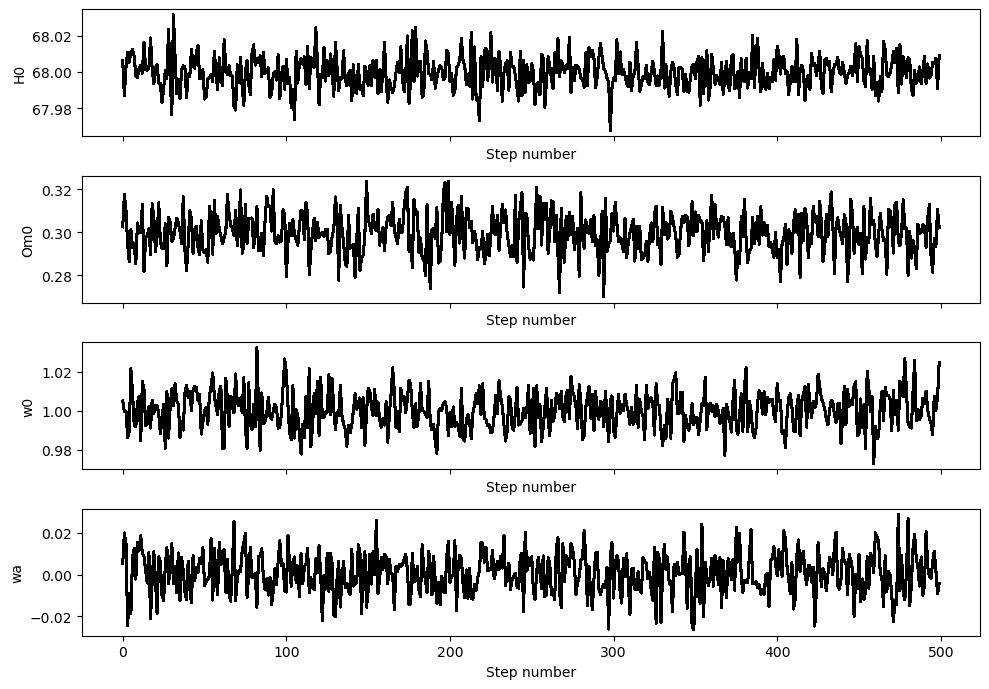

'\n# Plot the results\nfig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"])\nplt.show()\n'

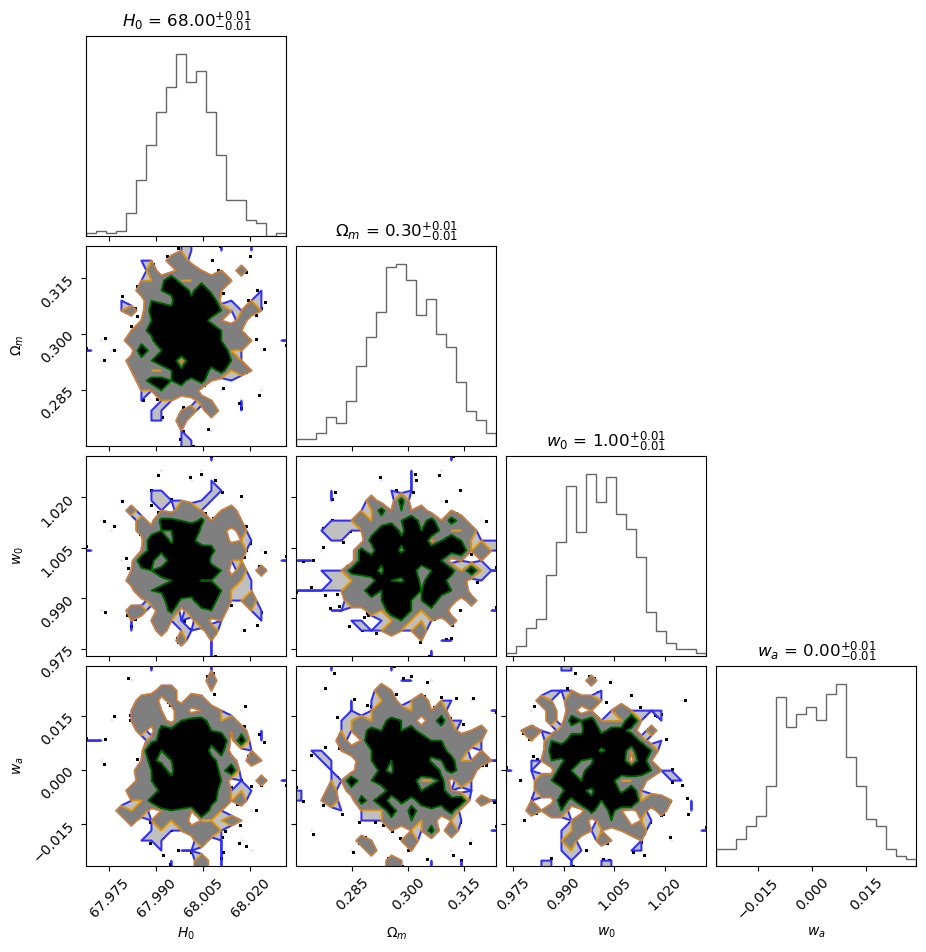

In [38]:
# Plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["H0", "Om0", "w0", "wa"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i], color="k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlabel("Step number")

plt.tight_layout()
plt.show()
'''
# Plot the results
smoothed_samples = gaussian_filter(samples, sigma=1, mode='nearest')
fig = corner.corner(smoothed_samples, labels=["H0", "Om0", "w0", "wa"], 
                    plot_contours=True, 
                    fill_contours=True, 
                    levels=(0.68, 0.95, 0.99),
                    contour_kwargs={"colors": "blue", "alpha": 0.75})
plt.show()
'''

# Plot the corner plot with enhanced aesthetics
fig = corner.corner(samples, labels=["$H_0$", "$\Omega_m$", "$w_0$", "$w_a$"], 
                    plot_contours=True, 
                    fill_contours=True, 
                    levels=(0.68, 0.95, 0.99),
                    contour_kwargs={"colors": ["blue", "orange", "green"], "alpha": 0.75},
                    show_titles=True, # Show the titles (mean and std)
                    title_fmt=".2f", # Format the title to 2 decimal places
                    title_kwargs={"fontsize": 12},
                    hist_kwargs={"density": True, "alpha": 0.6})
'''
# Customizing the plot to match the desired style
for ax in fig.get_axes():
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
    ax.tick_params(axis='both', which='major', labelsize=10)
'''
'''
# Plot the results
fig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"])
plt.show()
'''

# code of Mari

In [12]:

# Initialize the MCMC sampler
initial = np.array([68, 0.319, 0, -1, 0])
ndim = len(initial)
nwalkers = 50
#pos = initial + 1e-1 * np.random.randn(nwalkers, ndim)

# Separate standard deviations for different parameter groups
std_H0_Om0_Omr = 1e-2
std_w0_wa = 1e-2

# Create the initial positions with different standard deviations
pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_H0_Om0_Omr * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_H0_Om0_Omr * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_H0_Om0_Omr * np.random.randn(nwalkers)
pos[:, 3] = initial[3] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 4] = initial[4] + std_w0_wa * np.random.randn(nwalkers)


#'''
# Check initial likelihoods
for i in range(nwalkers):
    print(log_likelihood(pos[i], z_data, mu_data, Sigma_inv))

# Check initial posteriors
for i in range(nwalkers):
    print(log_posterior(pos[i], z_data, mu_data, Sigma_inv))
#'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data, mu_data, Sigma_inv))


SyntaxError: EOF while scanning triple-quoted string literal (1293364112.py, line 32)